In [20]:
# -*- coding:utf-8 -*-
import numpy as np
import json
import os
import pandas as pd
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import font_manager
zhfont=font_manager.FontProperties(fname='/usr/share/fonts/truetype/arphic/ukai.ttc')
from sklearn.metrics import roc_curve,auc,confusion_matrix,classification_report,roc_auc_score
from scipy import interp

import preprocessors.fft as fft
from utils.loader import load_test_data, load_train_data
from utils.config_name_creator import *
from commons import reshape_data
from commons import load_test_labels
from commons import print_cm



#全局变量
test_labels_path = '/home/vitamin/bigdata/code/kaggle-seizure-prediction/test_labels.csv'
Y_Test= DataFrame.from_csv(test_labels_path, index_col=None)
Y_True=Y_Test['preictal']
OBJS=['Dog_1','Dog_2','Dog_3','Dog_4','Dog_5','Patient_1','Patient_2']
PredFiles=['submission','submission_softmax','submission_minmax','submission_median']
def get_objects_y(y_test):
    y_objs={}
    for obj in OBJS:
        y_objs[obj]=y_test[y_test['clip'].str.contains(obj)]['preictal']
    return y_objs
Y_Objs=get_objects_y(Y_Test)

#函数
def get_preds(submission_path):
    datasets={}
    if 'models' in submission_path:
        submission_path=submission_path+'/submission'
        for fname in PredFiles:
            fs=fname.replace('_','')
            datasets[fname]=pd.read_csv(submission_path+'/'+fs+'.csv')['preictal']
        return datasets
    for fname in PredFiles:
        datasets[fname]=pd.read_csv(submission_path+'/'+fname+'.csv')['preictal']
    return datasets

def transform_lda_str(s):
    replace_dics={'LDA_fft_meanlog_lowcut0.1highcut180':'','nfreq_bands':'B:','win_length_sec':'_W:','stride_sec':'_L:'}
    for it in replace_dics:
        s=s.replace(it,replace_dics[it])
    return s
def transform_logreg_str(s):
    ss=s.split('_')
    ret='C:'+ss[1]
    return ret
def get_dirs(path,key_word):
    dirs=[]
    for p in os.listdir(path):
        if key_word in p:
            dirs.append(p)
    return dirs
def get_aucs(datasets):
    max_auc=0
    aucs=[]
    for fname in PredFiles:
        aucs.append(roc_auc_score(Y_True,datasets[fname]))
    max_idx=np.argmax(aucs)
    return max_idx,aucs




#need to update
def plot_model(path,key_word):
    models=get_dirs(path,key_word)
    auc_dics=[]
    max_datas={}
    total_max_data=None
    total_max_auc=0
    for model in models:
        submission_path=path+'/'+model
        datasets=get_preds(submission_path)
        max_idx,aucs=get_aucs(datasets)
        max_file=PredFiles[max_idx]
        max_auc=aucs[max_idx]
        if max_auc>total_max_auc:
            total_max_auc=max_auc
            total_max_data=path+'/'+model+'/'+max_file+'.csv'
        auc_dics.append(aucs)
        if 'LDA'in key_word:
            lda=transform_lda_str(model)
            lda=lda+'_'+max_file.replace('submission','')
            max_datas[lda]=datasets[max_file]
        elif 'logreg'in key_word:
            logreg=transform_logreg_str(model)
            logreg=logreg+'_'+max_file.replace('submission','')
            max_datas[logreg]=datasets[max_file]
        else:
            max_datas[model]=datasets[max_file]
    auc_df=pd.DataFrame(auc_dics,index=models,columns=PredFiles)
    outfile=key_word+'.csv'
    if not os.path.exists(outfile):
        auc_df.to_csv(key_word+'.csv')
    plot_roc(max_datas,title=u'%s模型校正最优ROC曲线'%(key_word))
    plot_objs_roc(total_max_data,title=u'%s最优性能下各预测对象的ROC曲线'%(key_word))
    plot_objs_Specificity(total_max_data,title=u'%s最优性能下各预测对象的特异性'%(key_word))
    plot_objs_Sensitivity(total_max_data,title=u'%s最优性能下各预测对象的敏感性'%(key_word))
    return


#plot

def plot_objs_roc(fname,title=u'ROC曲线'):
    print fname
    if not os.path.exists(fname):
        ss=fname.split('/')
        name=ss[len(ss)-1]
        sss=name.split('_')
        rep=sss[0]+'/'+sss[0]+sss[1]
        fname=fname.replace(name,rep)
    pred=pd.read_csv(fname)
    #print pred.head(5)
    y_pred=pred['preictal']
    objs_y_pred=get_objects_y(pred)
    #print objs_y_pred['Dog_2'].head(5)
    total_auc=roc_auc_score(Y_True,y_pred)
    print 'Total AUC: %s'%(total_auc)
    plt.figure(figsize=(10,7))
    #plot roc
    for obj in OBJS:
        #通过roc_curve()函数，求出fpr和tpr，以及阈值  
        fpr, tpr, thresholds = roc_curve(Y_Objs[obj],objs_y_pred[obj])
        obj_auc = auc(fpr, tpr)
        #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来,size=15,fontproperties=zhfont
        plt.plot(fpr, tpr, lw=2, label='%s(auc = %0.3f)'% (obj,obj_auc))
    #画对角线
    plt.plot([0, 1], [0, 1],'--',color=(0.6, 0.6, 0.6), label='Random')
    fpr, tpr, thresholds = roc_curve(Y_True,y_pred)
    #ROC曲线下的面积total
    obj_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,label='Total(auc = %0.3f)'% (total_auc),lw=4)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel(u'假阳性率',size=13,fontproperties=zhfont)  
    plt.ylabel(u'真阳性率',size=13,fontproperties=zhfont)  
    plt.title(title,size=17,fontproperties=zhfont)  
    plt.legend(loc="lower right")  
    plt.show()

def plot_roc(datasets,title=u'ROC曲线'):
    data_names=datasets.keys()
    print data_names
    plt.figure(figsize=(10,7))
    #plot roc
    for name in data_names:
        #通过roc_curve()函数，求出fpr和tpr，以及阈值
        fpr, tpr, thresholds = roc_curve(Y_True,datasets[name])
        obj_auc = auc(fpr, tpr)
        #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来,size=15,fontproperties=zhfont
        plt.plot(fpr, tpr, lw=2, label=u'%s(auc = %0.3f)'% (name,obj_auc))
    #画对角线
    plt.plot([0, 1], [0, 1],'--',color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel(u'假阳性率',size=13,fontproperties=zhfont)  
    plt.ylabel(u'真阳性率',size=13,fontproperties=zhfont)  
    plt.title(title,size=17,fontproperties=zhfont)  
    plt.legend(loc="lower right")  
    plt.show()
    return

def plot_Specificity(datasets,step=0.005,title=u'特异性曲线'):
    data_names=datasets.keys()
    print data_names
    plt.figure(figsize=(10,7))
    #plot roc
    t_list = np.arange(0.0, 1.0,step)
    y_zeros=Y_True.copy()
    y_zeros=np.zeros(Y_True.values.shape)
    for name in data_names:
        sn, sp = [], []
        for t in t_list:
            y_class=y_zeros.copy()
            y_class[datasets[name]>=t]=1
            cm=confusion_matrix(Y_True,y_class)
            sn_t = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
            sp_t = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
            sn.append(sn_t)
            sp.append(sp_t)
        plt.plot(t_list,sp, label=name, lw=2)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel(u'阈值',size=13,fontproperties=zhfont)  
    plt.ylabel(u'特异性',size=13,fontproperties=zhfont)  
    plt.title(title,size=17,fontproperties=zhfont)  
    plt.legend(loc="lower right")  
    plt.show()
    return


def plot_objs_Specificity(fname,step=0.005,title=u'特异性'):
    print fname
    if not os.path.exists(fname):
        ss=fname.split('/')
        name=ss[len(ss)-1]
        sss=name.split('_')
        rep=sss[0]+'/'+sss[0]+sss[1]
        fname=fname.replace(name,rep)
    pred=pd.read_csv(fname)
    #print pred.head(5)
    y_pred=pred['preictal']
    objs_y_pred=get_objects_y(pred)
    plt.figure(figsize=(10,7))
    #plot roc
    t_list = np.arange(0.0, 1.0,step)
    for obj in OBJS:
        sn, sp = [], []
        y_real=Y_Objs[obj]
        y_zeros=np.zeros(y_real.values.shape)
        for t in t_list:
            y_class=y_zeros.copy()
            y_class[objs_y_pred[obj]>=t]=1
            cm=confusion_matrix(y_real,y_class)
            sn_t = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
            sp_t = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
            sn.append(sn_t)
            sp.append(sp_t)
        plt.plot(t_list,sp, label=obj, lw=2)
    sn, sp = [], []
    y_zeros=np.zeros(Y_True.values.shape)
    for t in t_list:
        y_class=y_zeros.copy()
        y_class[y_pred>=t]=1
        cm=confusion_matrix(Y_True,y_class)
        sn_t = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
        sp_t = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
        sn.append(sn_t)
        sp.append(sp_t)
    
    plt.plot(t_list,sp, label='Total', lw=4)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel(u'阈值',size=13,fontproperties=zhfont)  
    plt.ylabel(u'特异性',size=13,fontproperties=zhfont)  
    plt.title(title,size=17,fontproperties=zhfont)  
    plt.legend(loc="lower right")  
    plt.show()
    return


def plot_Sensitivity(datasets,step=0.005,title=u'敏感性曲线'):
    data_names=datasets.keys()
    print data_names
    plt.figure(figsize=(10,7))
    #plot roc
    t_list = np.arange(0.0, 1.0,step)
    y_zeros=Y_True.copy()
    y_zeros=np.zeros(Y_True.values.shape)
    for name in data_names:
        sn, sp = [], []
        for t in t_list:
            y_class=y_zeros.copy()
            y_class[datasets[name]>=t]=1
            cm=confusion_matrix(Y_True,y_class)
            sn_t = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
            sp_t = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
            sn.append(sn_t)
            sp.append(sp_t)
        plt.plot(t_list,sn, label=name, lw=2)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel(u'阈值',size=13,fontproperties=zhfont)  
    plt.ylabel(u'敏感性',size=13,fontproperties=zhfont)  
    plt.title(title,size=17,fontproperties=zhfont)  
    plt.legend(loc="lower right")  
    plt.show()
    return


def plot_objs_Sensitivity(fname,step=0.005,title=u'敏感性'):
    print fname
    if not os.path.exists(fname):
        ss=fname.split('/')
        name=ss[len(ss)-1]
        sss=name.split('_')
        rep=sss[0]+'/'+sss[0]+sss[1]
        fname=fname.replace(name,rep)
    pred=pd.read_csv(fname)
    #print pred.head(5)
    y_pred=pred['preictal']
    objs_y_pred=get_objects_y(pred)
    plt.figure(figsize=(10,7))
    #plot roc
    t_list = np.arange(0.0, 1.0,step)
    for obj in OBJS:
        sn, sp = [], []
        y_real=Y_Objs[obj]
        y_zeros=np.zeros(y_real.values.shape)
        for t in t_list:
            y_class=y_zeros.copy()
            y_class[objs_y_pred[obj]>=t]=1
            cm=confusion_matrix(y_real,y_class)
            sn_t = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
            sp_t = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
            sn.append(sn_t)
            sp.append(sp_t)
        plt.plot(t_list,sn, label=obj, lw=2)
    sn, sp = [], []
    y_zeros=np.zeros(Y_True.values.shape)
    for t in t_list:
        y_class=y_zeros.copy()
        y_class[y_pred>=t]=1
        cm=confusion_matrix(Y_True,y_class)
        sn_t = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
        sp_t = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
        sn.append(sn_t)
        sp.append(sp_t)
    
    plt.plot(t_list,sn, label='Total', lw=4)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])  
    plt.xlabel(u'阈值',size=13,fontproperties=zhfont)  
    plt.ylabel(u'敏感性',size=13,fontproperties=zhfont)  
    plt.title(title,size=17,fontproperties=zhfont)  
    plt.legend(loc="lower right")  
    plt.show()
    return


['B:8_W:60_L:30__softmax', 'B:178_W:30_L:30__softmax', 'B:8_W:30_L:30__softmax']


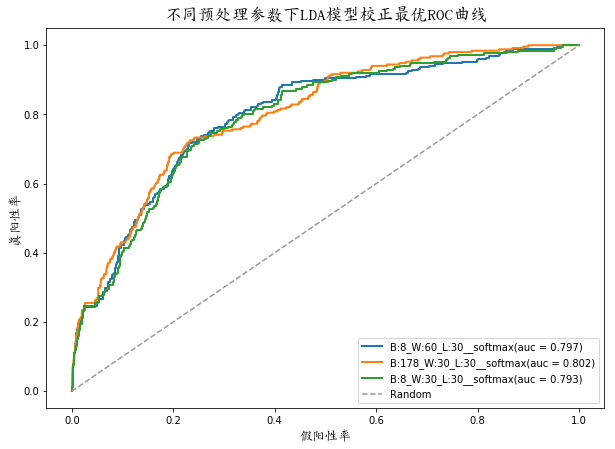

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands178win_length_sec30stride_sec30/submission_softmax.csv
Total AUC: 0.80191557332


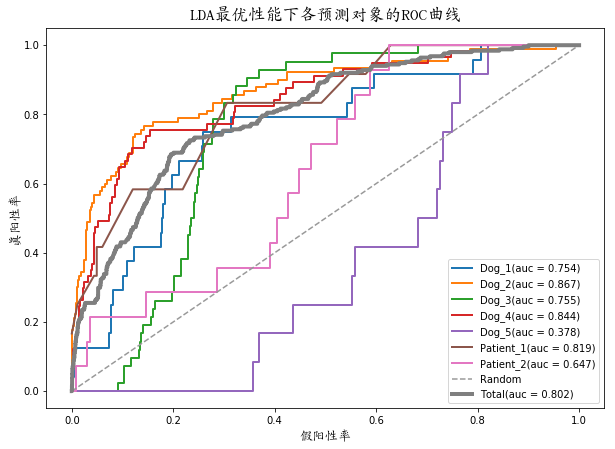

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands178win_length_sec30stride_sec30/submission_softmax.csv


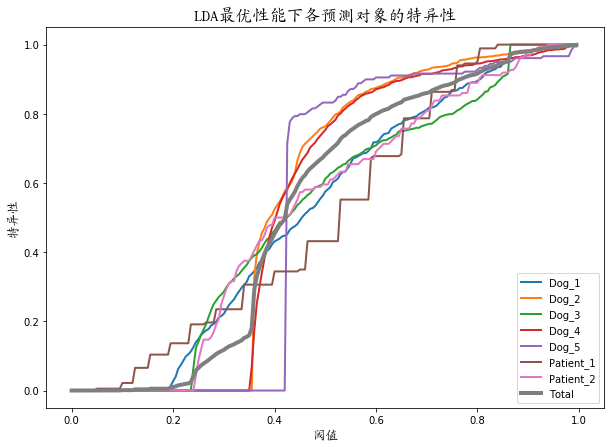

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands178win_length_sec30stride_sec30/submission_softmax.csv


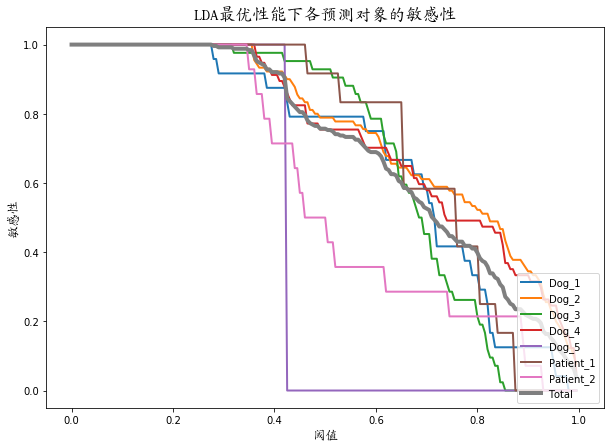

In [2]:
path='/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models'
key_word='LDA'
plot_model(path,key_word)

['C:10__softmax', 'C:100__softmax', 'C:0.01__softmax', 'C:1.0__softmax', 'C:10000000__softmax', 'C:0.1__softmax']


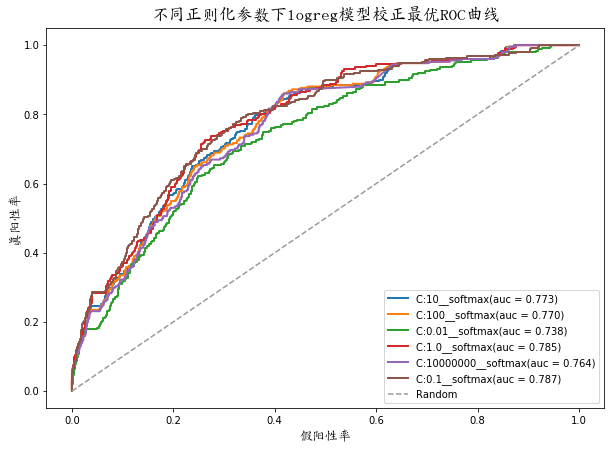

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/logreg_0.1_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission_softmax.csv
Total AUC: 0.786979119353


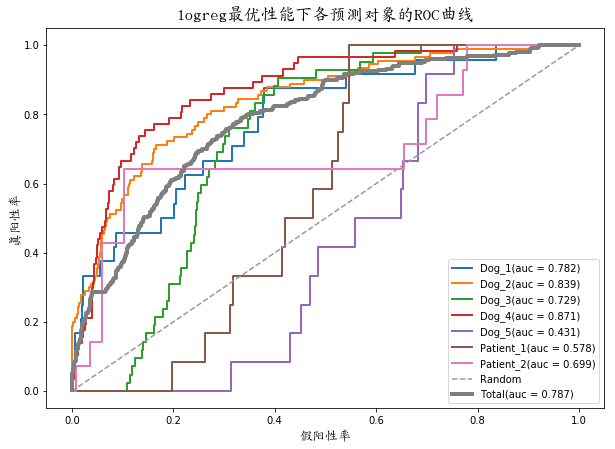

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/logreg_0.1_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission_softmax.csv


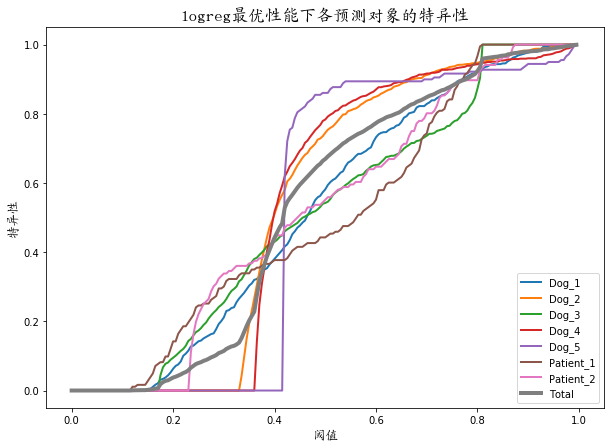

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/logreg_0.1_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission_softmax.csv


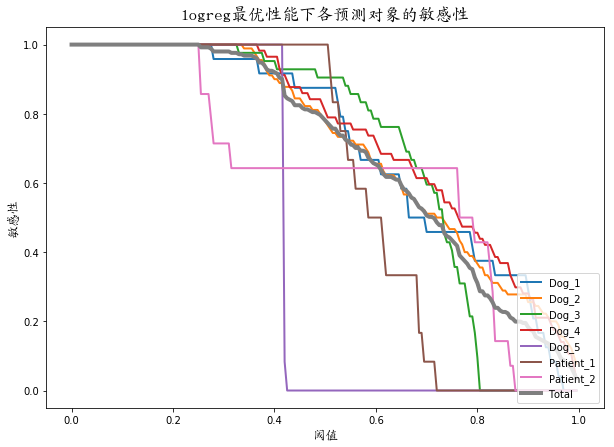

In [9]:
path='/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models'
key_word='logreg'
plot_model(path,key_word)

['nfreq6featumeanlog_stdhighc180lowcu0.1win_l60strid60globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl9strid[1, 2]train10weigh0.01scale1nkern[32, 64, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1', 'nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 1]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl0strid[1, 1]train10weigh0.01scale1nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1', 'nfreq6featumeanlog_stdhighc180lowcu0.1win_l60strid60globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.5, 0.5]overl0strid[1, 2]train10weigh0.01scale1nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1', 'nfreq6featumeanlog_stdhighc180lowcu0.1win_l60strid60globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl8strid[1, 2]train10weigh0.01scale1nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1', 'nfreq8featumeanlog_stdhighc180lowcu0.1win_l60strid60globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dro

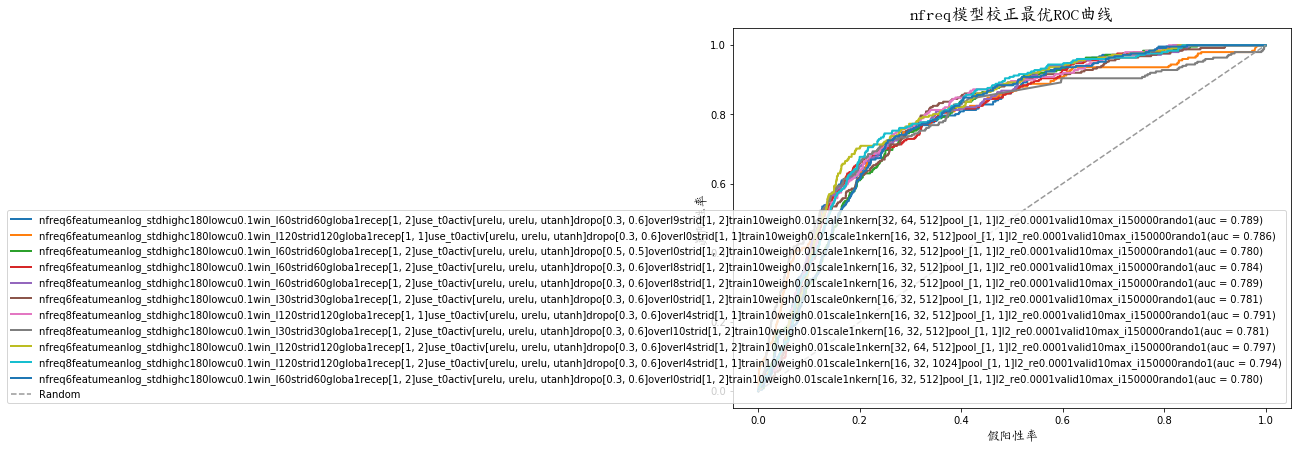

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl4strid[1, 2]train10weigh0.01scale1nkern[32, 64, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission_minmax.csv
Total AUC: 0.797461078595


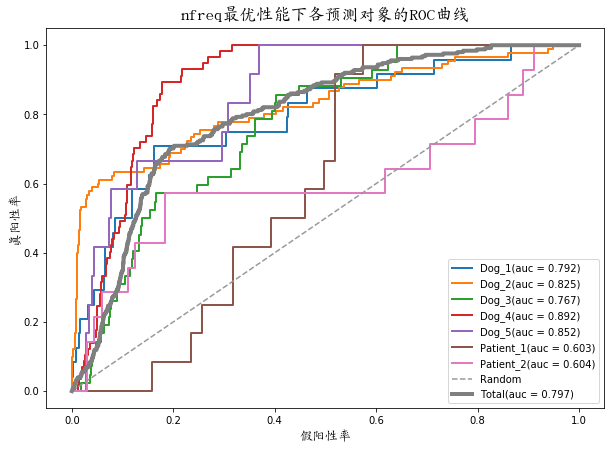

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl4strid[1, 2]train10weigh0.01scale1nkern[32, 64, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission_minmax.csv


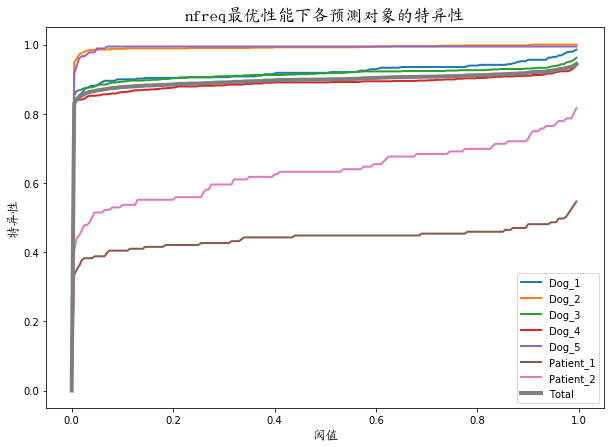

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl4strid[1, 2]train10weigh0.01scale1nkern[32, 64, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission_minmax.csv


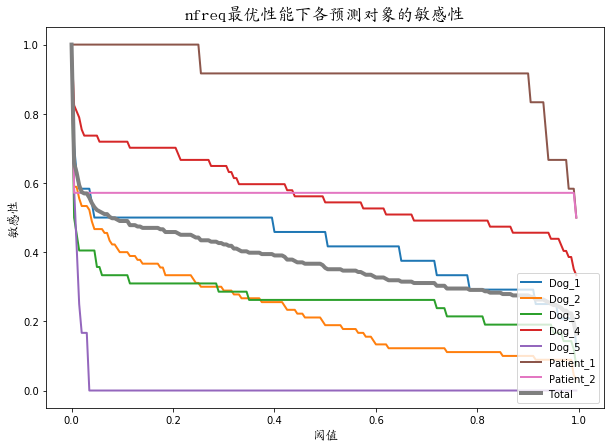

In [21]:
path='/home/bigdata/disk/data/seizure-prediction/kaggle_data/models'
key_word='nfreq'
plot_model(path,key_word)

['GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30', 'GRU_nepoch1_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30', 'GRU_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30', 'SimpleRNN_nepoch10_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30', 'LSTM_nepoch10_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30']


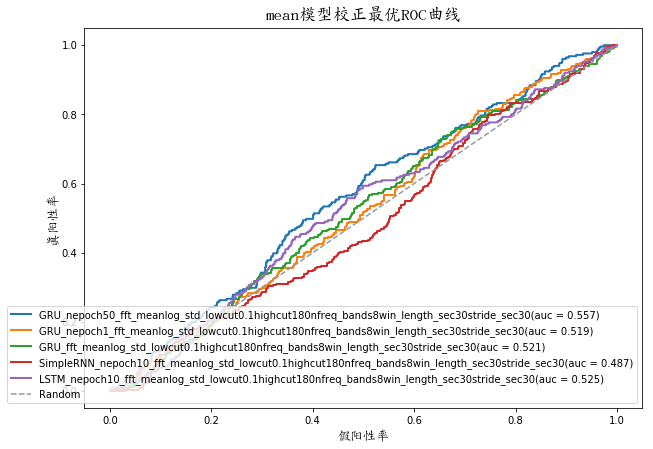

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30/submission.csv
Total AUC: 0.557378520662


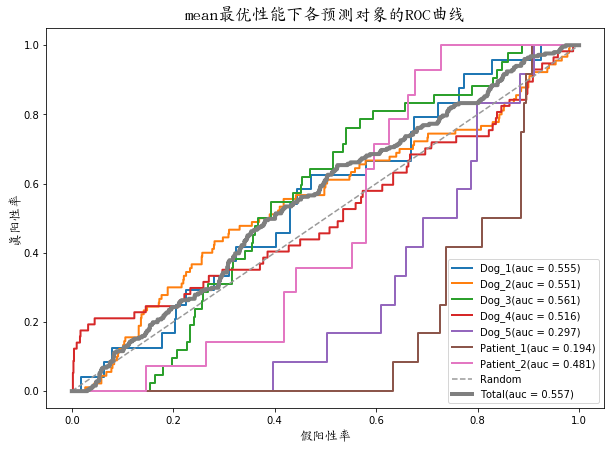

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30/submission.csv


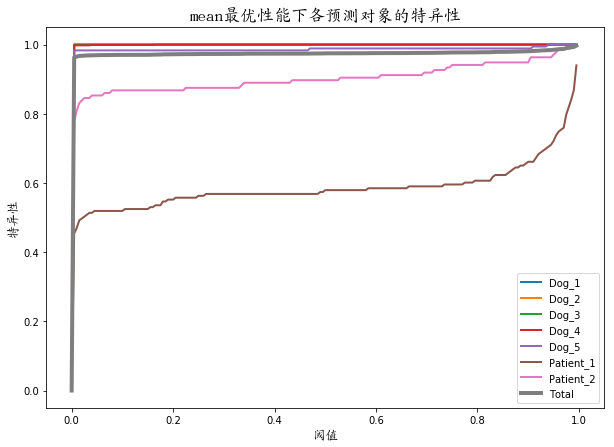

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30/submission.csv


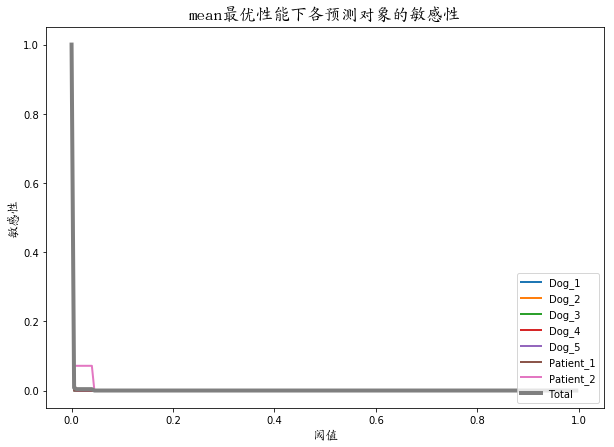

In [31]:
path='/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model'
key_word='mean'
plot_model(path,key_word)

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl4strid[1, 2]train10weigh0.01scale1nkern[32, 64, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission/submission.csv
Total AUC: 0.790155880279


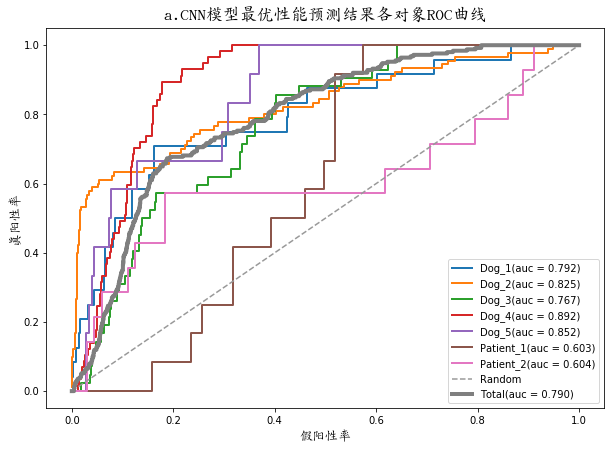

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission.csv
Total AUC: 0.747668392662


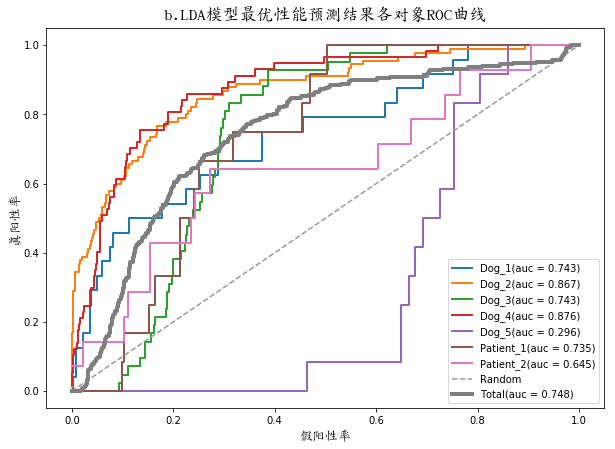

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/logreg_0.1_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission.csv
Total AUC: 0.684424084336


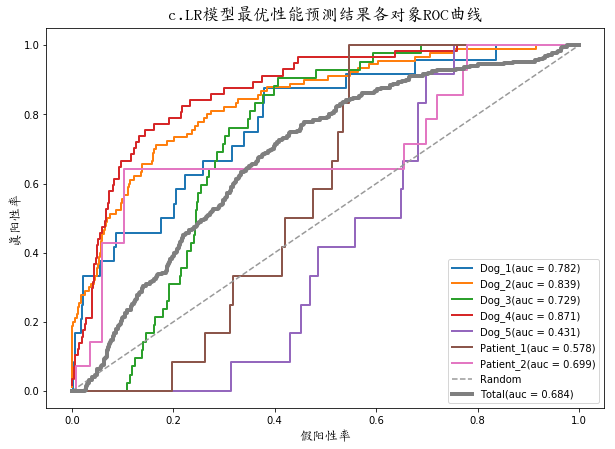

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30/submission.csv
Total AUC: 0.557378520662


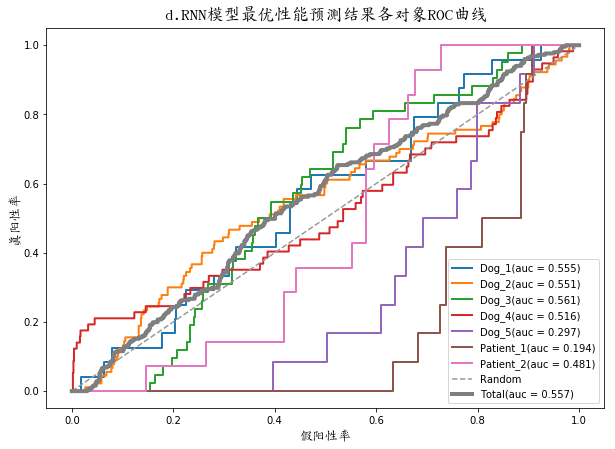

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl4strid[1, 2]train10weigh0.01scale1nkern[32, 64, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission/submission.csv


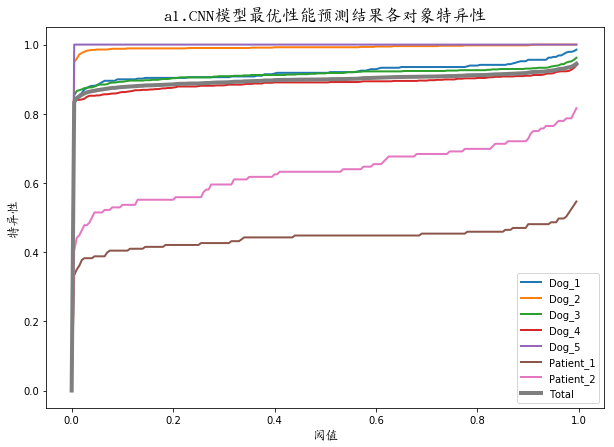

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission.csv


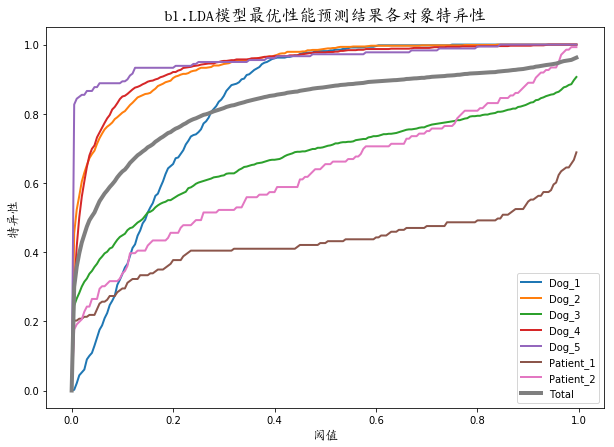

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/logreg_0.1_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission.csv


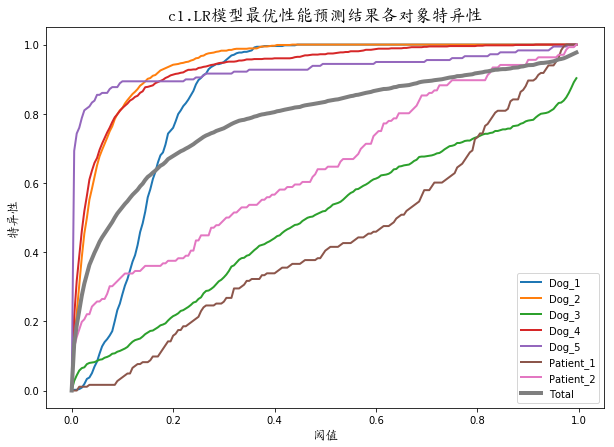

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30/submission.csv


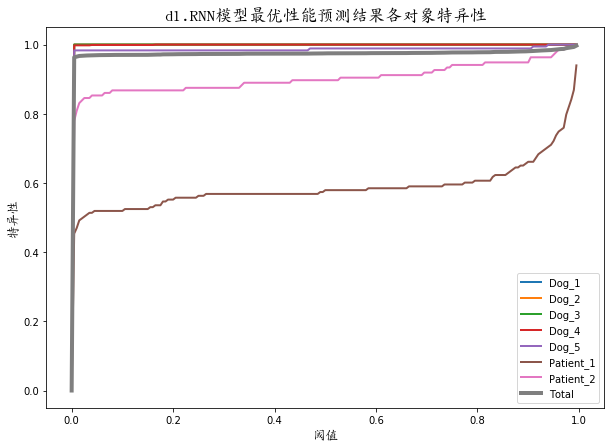

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl4strid[1, 2]train10weigh0.01scale1nkern[32, 64, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission/submission.csv


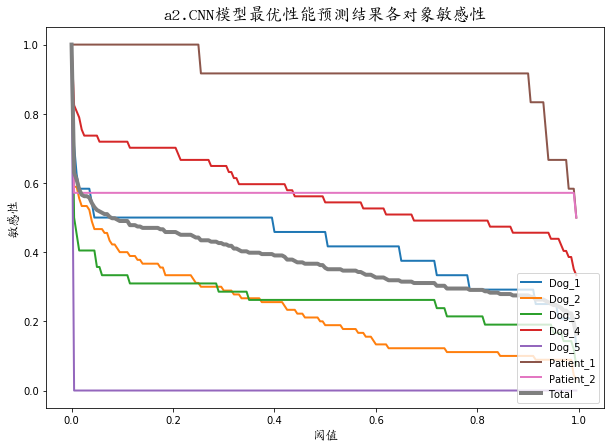

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission.csv


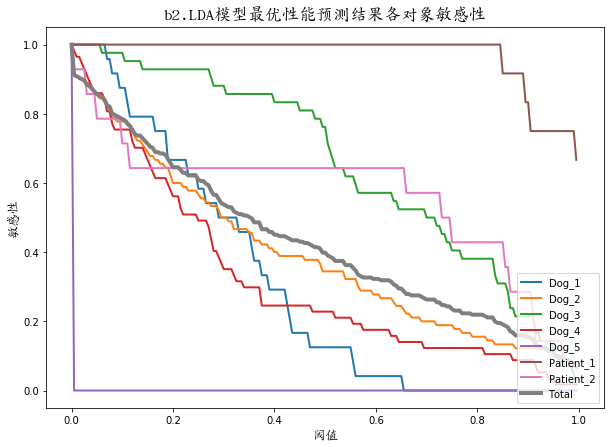

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/logreg_0.1_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30/submission.csv


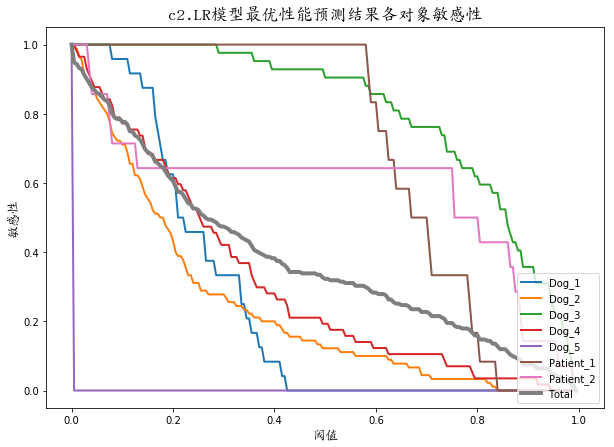

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30/submission.csv


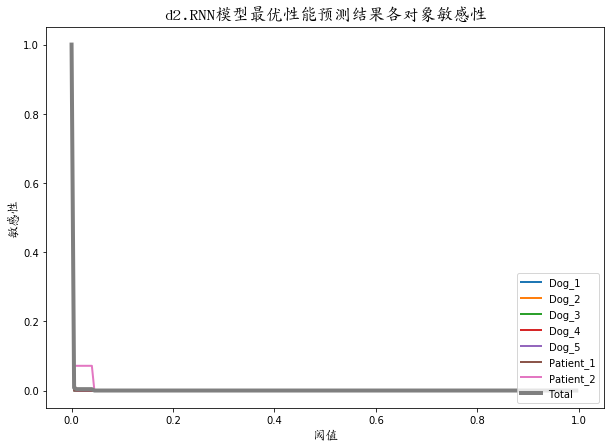

In [29]:
path='/home/bigdata/disk/data/seizure-prediction/kaggle_data/models'
b_path='/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions'
dirs=get_dirs(path,'nfreq')
cnn_fname='/submission/submission.csv'
other_fname='/submission.csv'
max_cnn=''
for d in dirs:
    if 'nfreq6' in d and 'win_l120strid120' in d and 'nkern[32, 64, 512]' in d:
        max_cnn='/'+d
        break
max_cnn=path+max_cnn
max_lda=b_path+'/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30'
max_lr=b_path+'/linear_models/logreg_0.1_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30'
max_rnn=b_path+'/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30'
plot_objs_roc(max_cnn+cnn_fname,title=u'a.CNN模型最优性能预测结果各对象ROC曲线')
plot_objs_roc(max_lda+other_fname,title=u'b.LDA模型最优性能预测结果各对象ROC曲线')
plot_objs_roc(max_lr+other_fname,title=u'c.LR模型最优性能预测结果各对象ROC曲线')
plot_objs_roc(max_rnn+other_fname,title=u'd.RNN模型最优性能预测结果各对象ROC曲线')

plot_objs_Specificity(max_cnn+cnn_fname,title=u'a1.CNN模型最优性能预测结果各对象特异性')
plot_objs_Specificity(max_lda+other_fname,title=u'b1.LDA模型最优性能预测结果各对象特异性')
plot_objs_Specificity(max_lr+other_fname,title=u'c1.LR模型最优性能预测结果各对象特异性')
plot_objs_Specificity(max_rnn+other_fname,title=u'd1.RNN模型最优性能预测结果各对象特异性')

plot_objs_Sensitivity(max_cnn+cnn_fname,title=u'a2.CNN模型最优性能预测结果各对象敏感性')
plot_objs_Sensitivity(max_lda+other_fname,title=u'b2.LDA模型最优性能预测结果各对象敏感性')
plot_objs_Sensitivity(max_lr+other_fname,title=u'c2.LR模型最优性能预测结果各对象敏感性')
plot_objs_Sensitivity(max_rnn+other_fname,title=u'd2.RNN模型最优性能预测结果各对象敏感性')